In [8]:
# Standard library
import os
import numpy as np
from numpy import linalg

# Third-party libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from PIL import Image
import scipy

# Astropy (astronomy-specific tools)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS

# Scientific colormaps
from cmcrameri import cm

# Matplotlib extensions
from mpl_toolkits.axes_grid1 import make_axes_locatable

from reproject import reproject_interp
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import numpy as np

from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import numpy as np
import matplotlib.pyplot as plt
from reproject import reproject_interp

from scipy.ndimage import gaussian_filter
from astropy.convolution import Gaussian2DKernel, convolve

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# First exercise: integrate the HIPASS Cube

In [9]:
hipass_path = '/Users/user/phd/rrl_hipass_gdigs/maps/hipass/'
hipass_cube = fits.open(hipass_path + 'RRL_H166-167-168a_HIPASS+ZOA_lbv.fits')
print(hipass_cube[0].data.shape)

hipass_integrated = fits.open(hipass_path + 'RRL_H166-167-168a_HIPASS+ZOA_TLdv.fits')

(51, 151, 3249)


In [10]:
#hipass_cube[0].header

In [11]:
# Create the velocity space
vel_ref =  hipass_cube[0].header['CRPIX3'] - 1
min_vel =  hipass_cube[0].header['CDELT3'] * (vel_ref)
max_vel = -hipass_cube[0].header['CDELT3'] * (vel_ref)
vel_space = np.linspace(min_vel, max_vel, 2*vel_ref+1)

In [12]:
integrated_hipass = np.zeros_like(hipass_cube[0].data[0,:,:])
for i in range(integrated_hipass.shape[0]):
    for j in range(integrated_hipass.shape[1]):
        integrated_hipass[i,j] = np.trapz(hipass_cube[0].data[:,i,j]*1e-3, vel_space)

In [13]:
#hipass_integrated[0].header

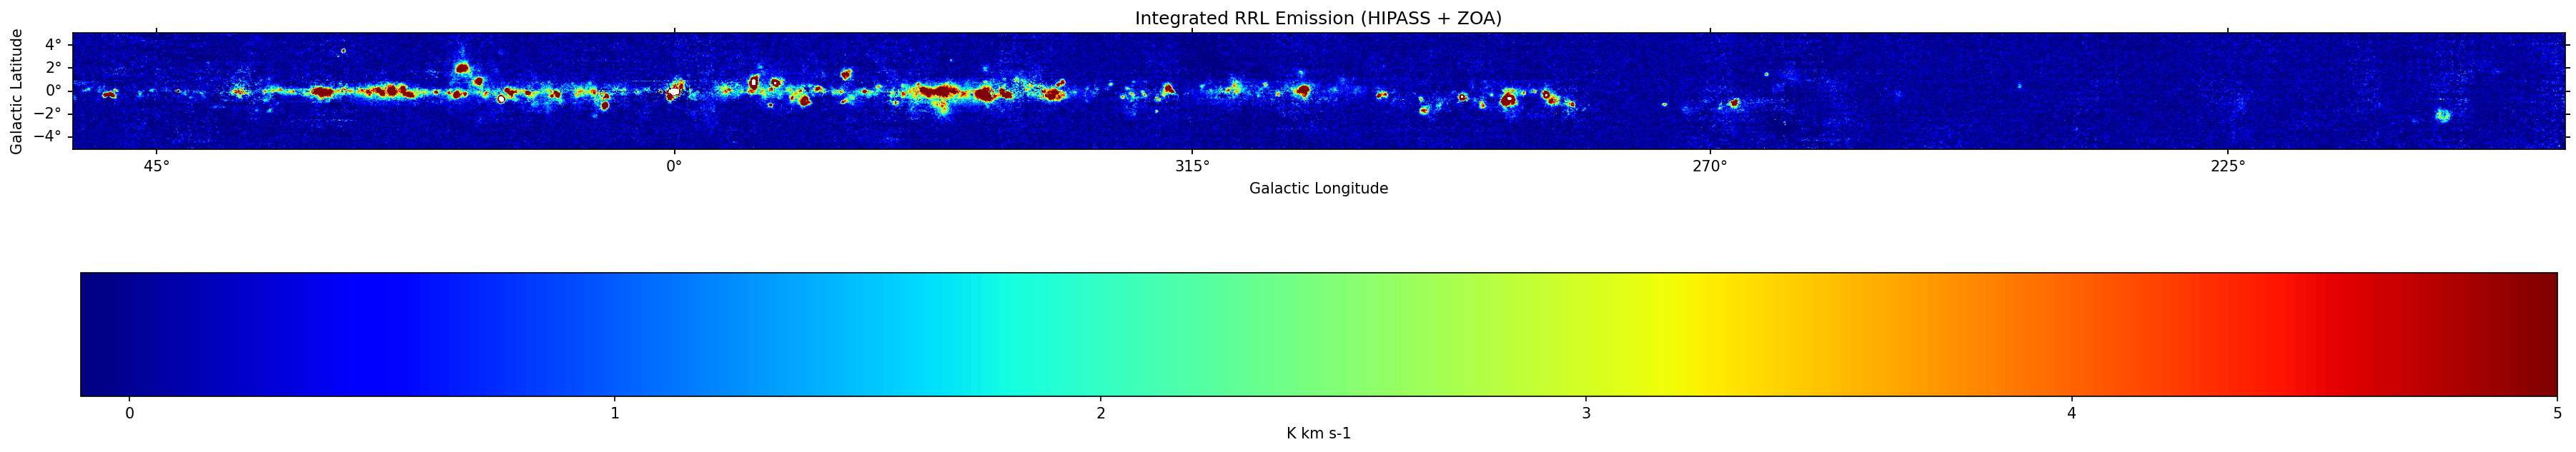

In [14]:
# Plot com WCS
header = hipass_cube[0].header
wcs = WCS(header).celestial
fig = plt.figure(figsize=(30, 10), dpi=150)
ax = fig.add_subplot(111, projection=wcs) 
im = ax.imshow(integrated_hipass, origin='lower', vmin=-0.1, vmax=5, cmap='jet')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.colorbar(im, ax=ax, label='K km s-1', orientation='horizontal')
plt.title('Integrated RRL Emission (HIPASS + ZOA)')
plt.show()

In [26]:
import numpy as np
from scipy.optimize import curve_fit
from math import erf, sqrt, pi

def gaussian(v, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((v - mu)/sigma)**2)

vel = vel_space  # eixo de velocidades

integrated_hipass = np.zeros_like(hipass_cube[0].data[0,:,:], dtype=float)

for i in range(integrated_hipass.shape[0]):
    for j in range(integrated_hipass.shape[1]):
        spectrum = hipass_cube[0].data[:,i,j] * 1e-3

        # se toda a linha é NaN → resultado NaN
        if np.all(np.isnan(spectrum)):
            integrated_hipass[i,j] = np.nan
            continue

        # substituir NaNs por zero
        spectrum = np.nan_to_num(spectrum, nan=0.0, posinf=0.0, neginf=0.0)

        # chute inicial
        amp0 = spectrum.max()
        mu0  = vel[np.argmax(spectrum)]
        sigma0 = 20.0

        try:
            popt, _ = curve_fit(
                gaussian, vel, spectrum,
                p0=[amp0, mu0, sigma0],
                maxfev=2000
            )
            amp, mu, sigma = popt

            # integral da gaussiana em ±3σ
            factor = erf(3/sqrt(2))  # ≈ 0.9973
            integrated_hipass[i,j] = amp * sigma * sqrt(2*pi) * factor

        except Exception:
            integrated_hipass[i,j] = 0 #np.nan


/Users/user/code/python3.11.8/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


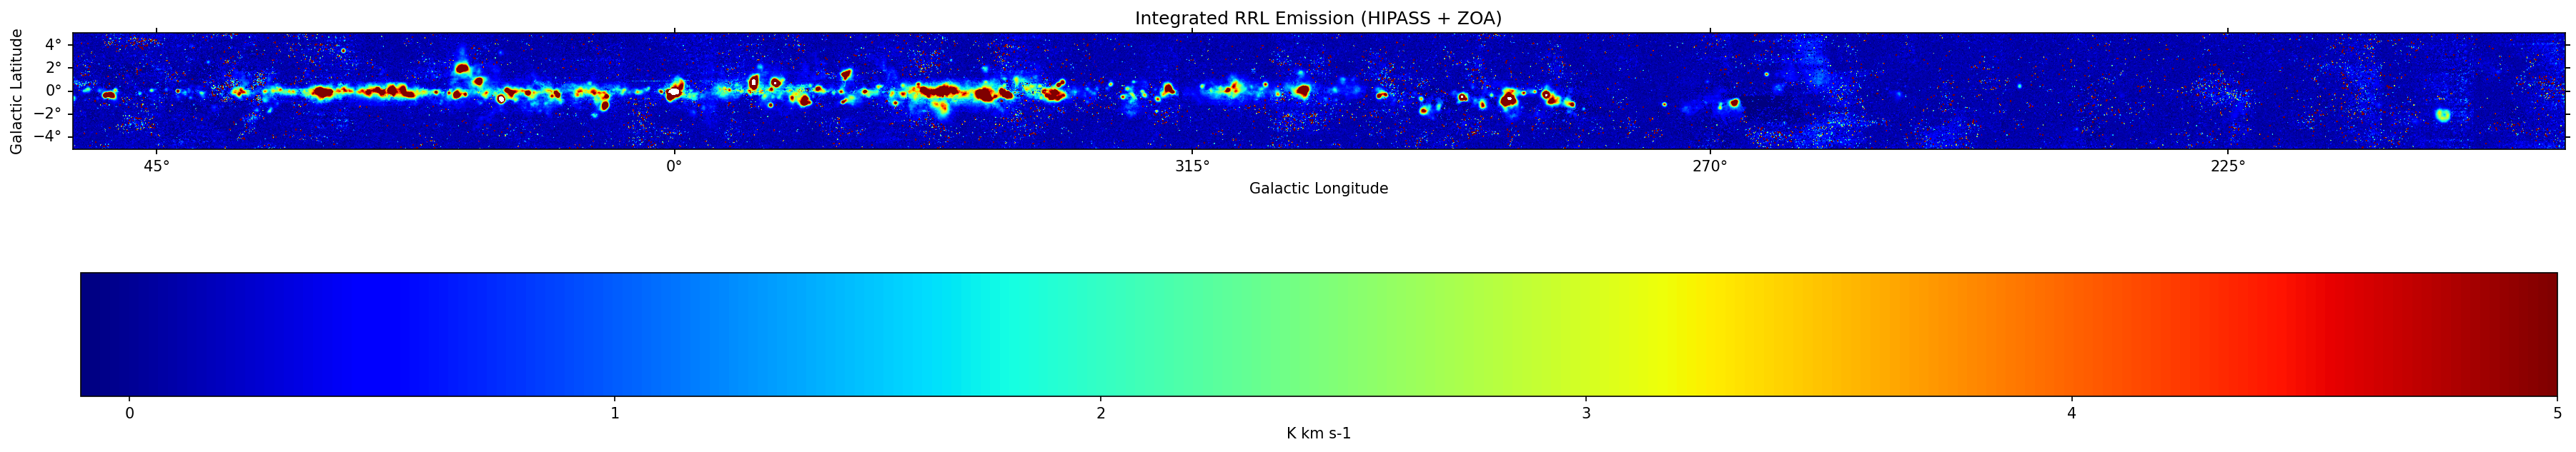

In [27]:
# Plot com WCS
#integrated_hipass[integrated_hipass == np.nan] = 0.0
header = hipass_cube[0].header
wcs = WCS(header).celestial
fig = plt.figure(figsize=(30, 10), dpi=150)
ax = fig.add_subplot(111, projection=wcs) 
im = ax.imshow(integrated_hipass, origin='lower', vmin=-0.1, vmax=5, cmap='jet')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.colorbar(im, ax=ax, label='K km s-1', orientation='horizontal')
plt.title('Integrated RRL Emission (HIPASS + ZOA)')
plt.show()

In [65]:
39*38*37*12

658008

In [71]:
import math
math.factorial(40)/ (math.factorial(40-15) * math.factorial(15))

40225345056.0

In [72]:
math.factorial(15) / (math.factorial(15-5) * math.factorial(5))

3003.0

In [74]:
1.22*299792458 /(4.76e9) / (7.6) * 180 / np.pi * 60

34.75632674596747

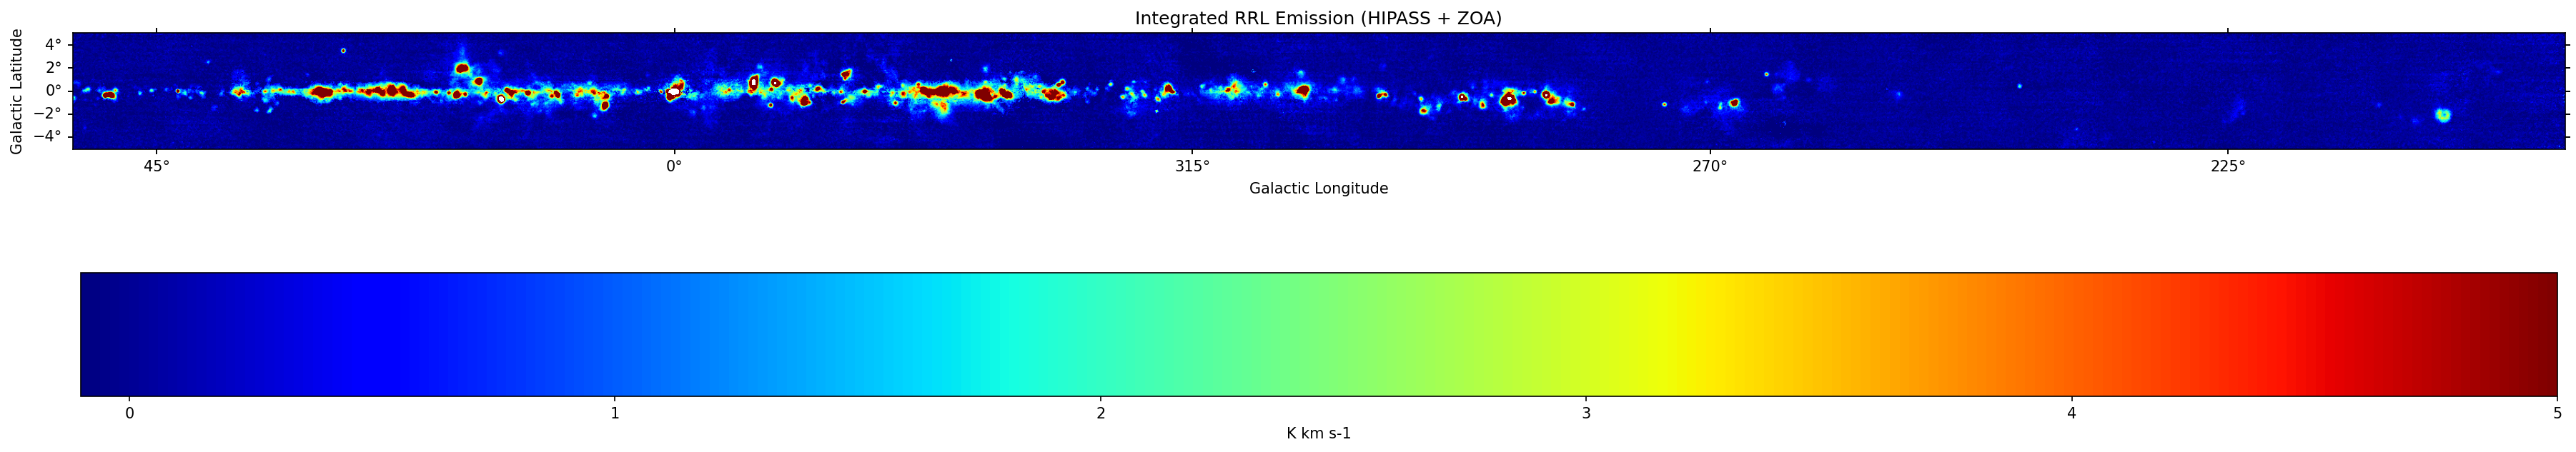

In [9]:
# Plot com WCS
header = hipass_cube[0].header
wcs = WCS(header).celestial
fig = plt.figure(figsize=(30, 10), dpi=150)
ax = fig.add_subplot(111, projection=wcs) 
im = ax.imshow(hipass_integrated[0].data, origin='lower', vmin=-0.1, vmax=5, cmap='jet')
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')
plt.colorbar(im, ax=ax, label='K km s-1', orientation='horizontal')
plt.title('Integrated RRL Emission (HIPASS + ZOA)')
plt.show()

# 2. Integrate a GDIGS cube

In [120]:
1/98,1/166+1/167+1/168,1/98/(1/166+1/167+1/168)

(0.01020408163265306, 0.01796450129001893, 0.5680136324364564)

In [53]:
gdigs_path = '/Users/user/phd/comap/GDIGS/Alpha/small/'
gdigs_cube = fits.open(gdigs_path + 'GDIGS_G000.50-00.90_halpha_2pol_average.fits')
print(gdigs_cube[0].data[0].shape)

gdigs_integrated = fits.open(gdigs_path + 'GDIGS_G000.50-00.90_halpha_2pol_average_moment0.fits')

(1201, 96, 120)


In [54]:
#gdigs_cube[0].header

In [55]:
# Create the velocity space
gdigs_vel_ref =  gdigs_cube[0].header['CRPIX3'] - 1
gdigs_min_vel = -gdigs_cube[0].header['CRVAL3']
gdigs_max_vel =  gdigs_cube[0].header['CRVAL3']
gdigs_vel_space = np.linspace(gdigs_min_vel, gdigs_max_vel, gdigs_cube[0].header['NAXIS3'] )

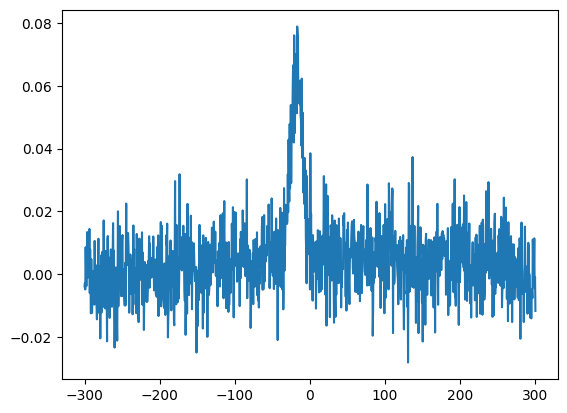

In [56]:
plt.plot(gdigs_vel_space, gdigs_cube[0].data[0,:,53,82], label='GDIGS')

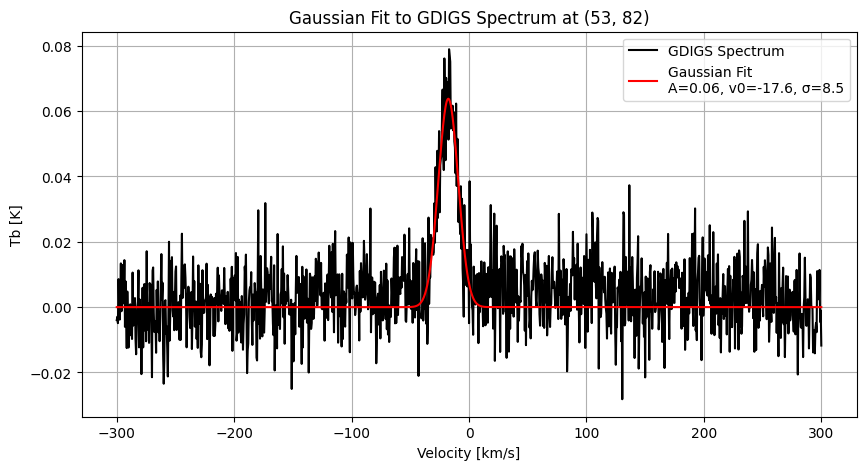

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Dados
spectrum = gdigs_cube[0].data[0,:,53,82]
velocity = gdigs_vel_space

# Máscara para valores válidos
mask = np.isfinite(spectrum)

# Definição da gaussiana
def gaussian(v, A, v0, sigma):
    return A * np.exp(-0.5 * ((v - v0) / sigma)**2)

# Estimativas iniciais
A0 = np.nanmax(spectrum)
v0 = velocity[np.nanargmax(spectrum)]
sigma0 = 20.0  # km/s, chute razoável

# Ajuste
popt, _ = curve_fit(gaussian, velocity[mask], spectrum[mask],
                    p0=[A0, v0, sigma0],
                    bounds=([0, -300, 1], [np.inf, 300, 100]))

# Valores ajustados
A_fit, v0_fit, sigma_fit = popt
gauss_fit = gaussian(velocity, A_fit, v0_fit, sigma_fit)

# Plot
plt.figure(figsize=(10,5))
plt.plot(velocity, spectrum, label='GDIGS Spectrum', color='black')
plt.plot(velocity, gauss_fit, label=f'Gaussian Fit\nA={A_fit:.2f}, v0={v0_fit:.1f}, σ={sigma_fit:.1f}', color='red')
plt.xlabel('Velocity [km/s]')
plt.ylabel('Tb [K]')
plt.title('Gaussian Fit to GDIGS Spectrum at (53, 82)')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
integrated_gdigs = np.zeros_like(gdigs_cube[0].data[0,0,:,:])
for i in range(integrated_gdigs.shape[0]):
    for j in range(integrated_gdigs.shape[1]):
        integrated_gdigs[i,j] = -np.trapz(gdigs_cube[0].data[0,:,i,j], gdigs_vel_space)

In [61]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad

# Função gaussiana
def gaussian(v, A, v0, sigma):
    return A * np.exp(-0.5 * ((v - v0) / sigma)**2)

# Integração analítica da gaussiana
def gaussian_integral(A, sigma):
    return A * sigma * np.sqrt(2 * np.pi)

# Dados
cube = gdigs_cube[0].data[0]  # shape: (vel, lat, lon)
velocities = gdigs_vel_space
n_lat, n_lon = cube.shape[1], cube.shape[2]

# Mapa de saída
fitted_integrated = np.full((n_lat, n_lon), np.nan)

# Loop
for i in range(n_lat):
    for j in range(n_lon):
        spectrum = cube[:, i, j]

        # Máscara para valores válidos
        mask = np.isfinite(spectrum)

        if np.count_nonzero(mask) < 5:
            continue

        try:
            # Estimativas iniciais
            A0 = np.nanmax(spectrum)
            v0 = velocities[np.nanargmax(spectrum)]
            sigma0 = 20.0  # km/s, exemplo

            popt, _ = curve_fit(gaussian, velocities[mask], spectrum[mask],
                                p0=[A0, v0, sigma0],
                                bounds=([0, -300, 1], [np.inf, 300, 100]))

            A_fit, v0_fit, sigma_fit = popt
            fitted_integrated[i, j] = gaussian_integral(A_fit, sigma_fit)

        except RuntimeError:
            continue  # ajuste falhou



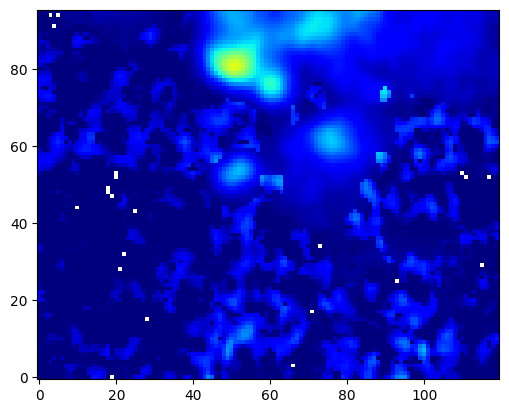

In [62]:
plt.imshow(fitted_integrated, origin='lower', cmap='jet', vmin=0.0109343, vmax=16.7243)

In [59]:
gdigs_integrated[0].data.shape

(96, 120)

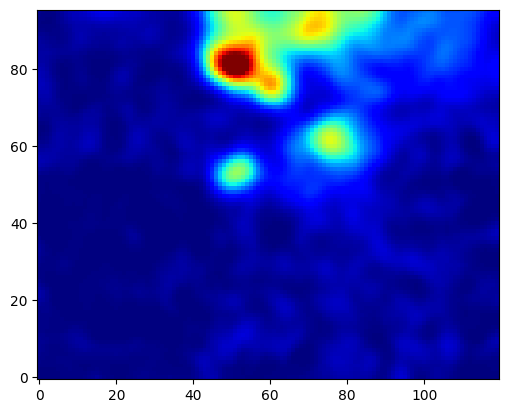

In [60]:
plt.imshow(gdigs_integrated[0].data, origin='lower', cmap='jet', vmin=0.0109343, vmax=16.7243)